In [4]:
import os
from dataclasses import dataclass
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [7]:
@dataclass
class InputPath:
    _prefix: str = "../input/dataset_atmaCup11"
    photo_prefix: str = f"{_prefix}/photos"
    train: str = f"{_prefix}/train.csv"
    test: str = f"{_prefix}/test.csv"


def load_csv(path: str) -> pd.DataFrame:
    return pd.read_csv(path)


def get_image_path(object_id: str) -> str:
    return os.path.join(InputPath.photo_prefix, f"{object_id}.jpg")


def read_image(object_id: str) -> np.array:
    path = get_image_path(object_id)
    im = Image.open(path)
    im_array = np.asarray(im)
    return im_array

In [8]:
import torch
import imagehash
from tqdm import tqdm


def run_imagehash(df: pd.DataFrame) -> Tuple[List[str], np.array]:
    funcs = [
        imagehash.average_hash,
        imagehash.phash,
        imagehash.dhash,
        imagehash.whash,
    ]
    object_ids: List[str] = []
    hashes: List[np.array] = []
    for object_id in tqdm(set(df["object_id"].values.tolist())):
        path = get_image_path(object_id)
        image = Image.open(path)
        hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))
        object_ids.append(object_id)
    return object_ids, np.array(hashes)


train = load_csv(InputPath.train)
test = load_csv(InputPath.test)
train_test = pd.concat((train, test), axis=0, ignore_index=True)
%time object_ids, hashes_all = run_imagehash(train_test)

100%|██████████| 9856/9856 [00:45<00:00, 216.67it/s]

CPU times: user 45.4 s, sys: 328 ms, total: 45.7 s
Wall time: 45.5 s


In [9]:
hashes_all = torch.Tensor(hashes_all.astype(int)).cuda()
sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).cpu().numpy()/256 for i in range(hashes_all.shape[0])])

In [62]:
threshold = 0.88

indices1 = np.where(sims > threshold)
indices2 = np.where(indices1[0] != indices1[1])
object_ids1 = [object_ids[i] for i in indices1[0][indices2]]
object_ids2 = [object_ids[i] for i in indices1[1][indices2]]
dups = {tuple(sorted([object_id1, object_id2])):True for object_id1, object_id2 in zip(object_ids1, object_ids2)}
print(f'found {len(dups)} duplicates')

found 67 duplicates


after: 1, before: 3.0


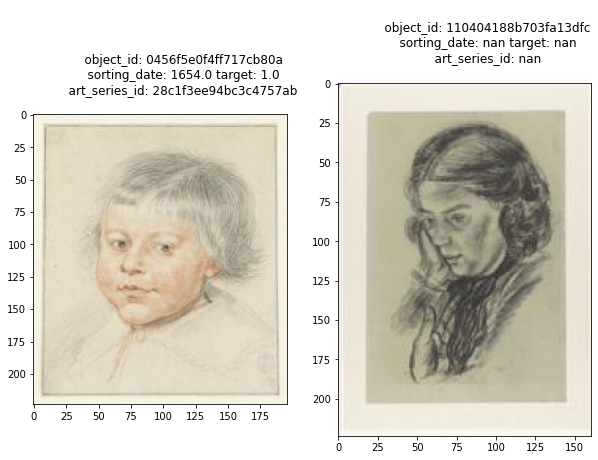

after: 3, before: 2.09835035


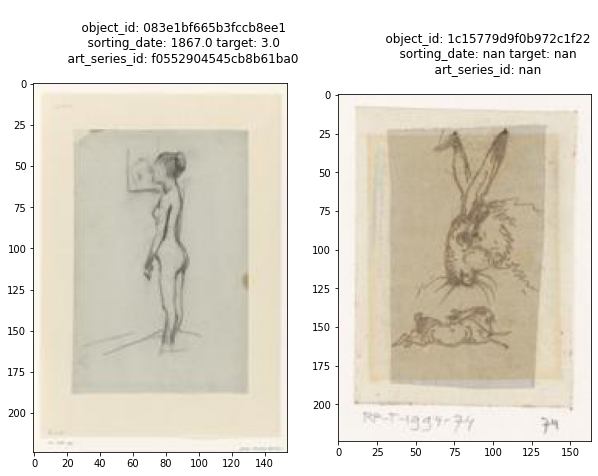

after: 3, before: 2.627320275


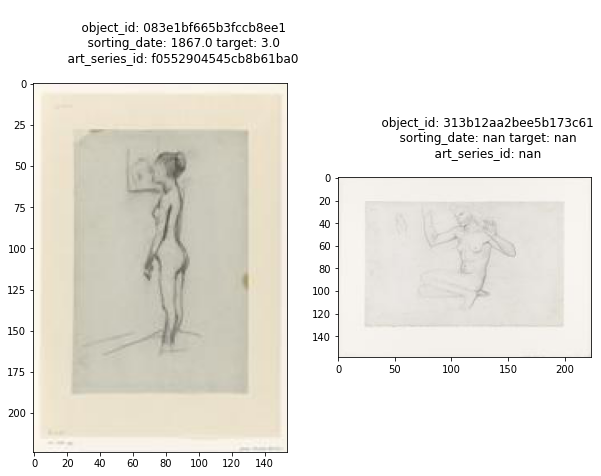

after: 3, before: 2.95114675


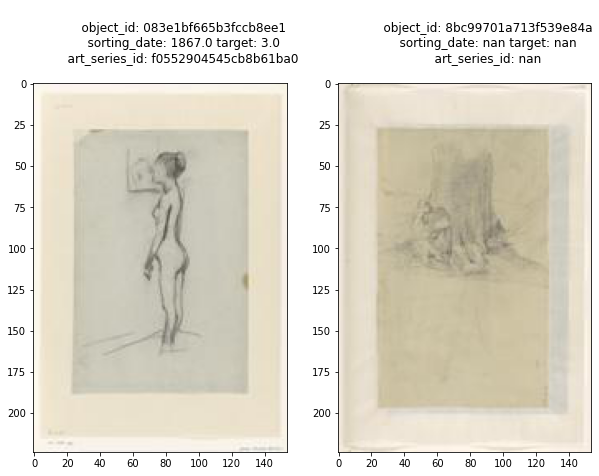

after: 0, before: 2.9475311000000004


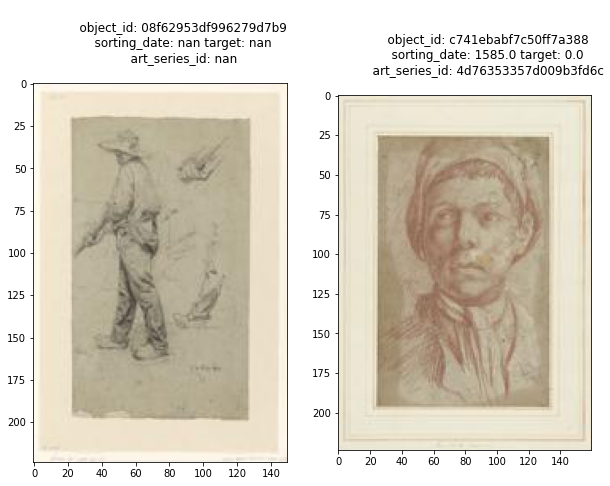

after: 2, before: 1.4652894


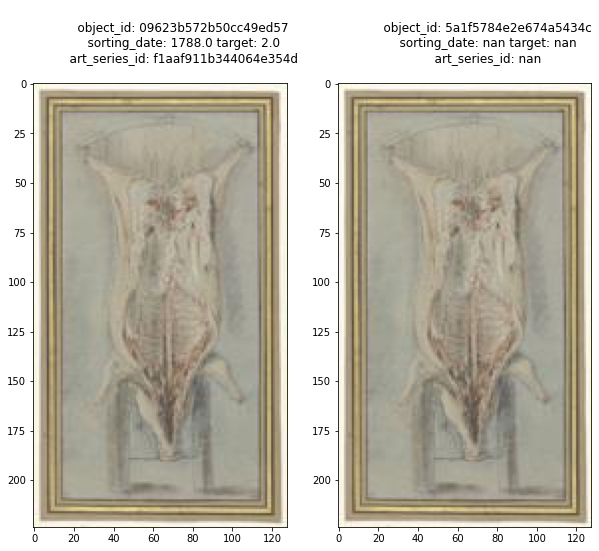

after: 2, before: 1.950558825


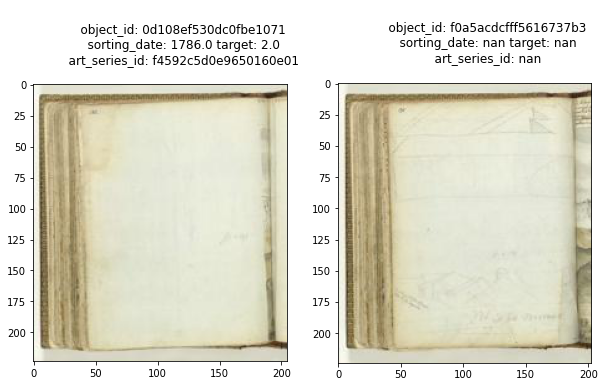

after: 3, before: 2.48698495


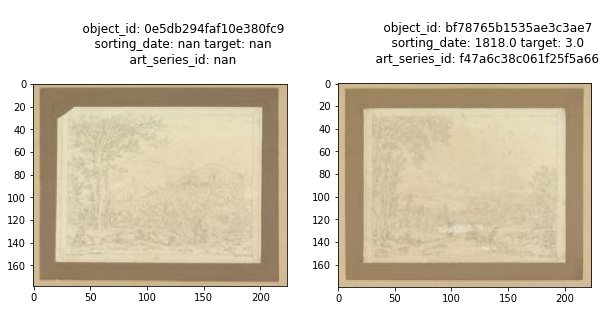

after: 3, before: 3.0


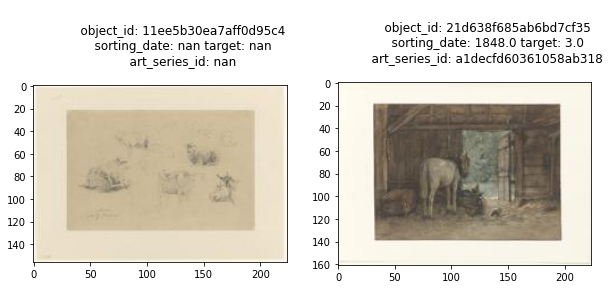

after: 2, before: 1.717275275


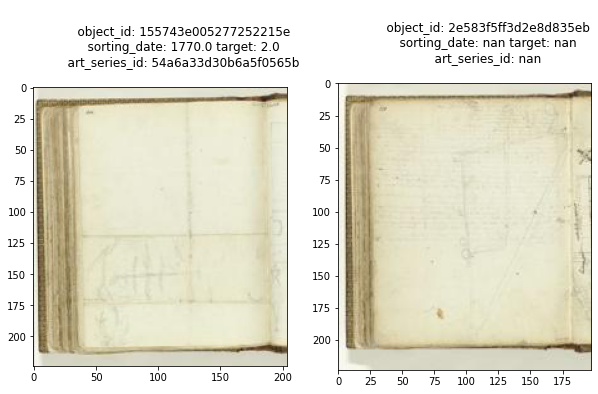

after: 2, before: 1.941334375


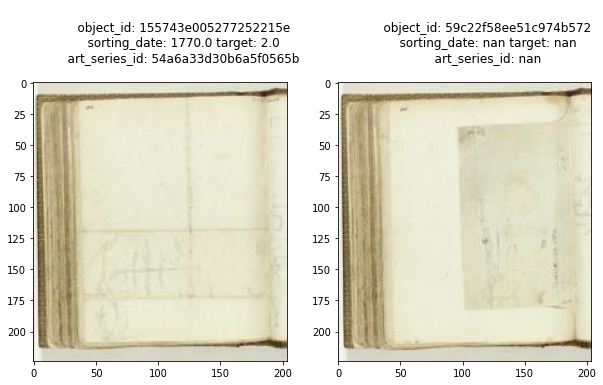

after: 3, before: 2.254743675


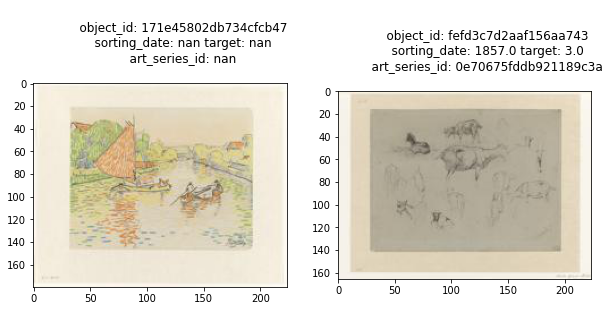

after: 2, before: 1.21566625


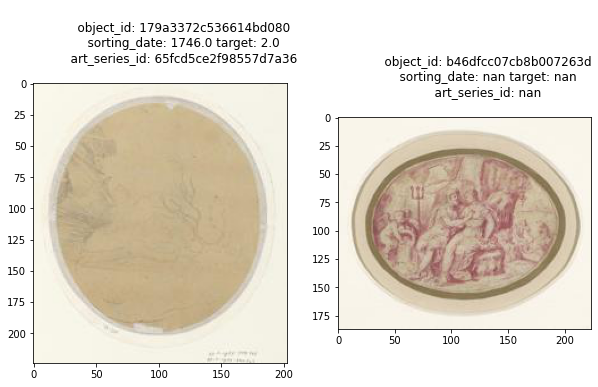

after: 3, before: 2.8912025


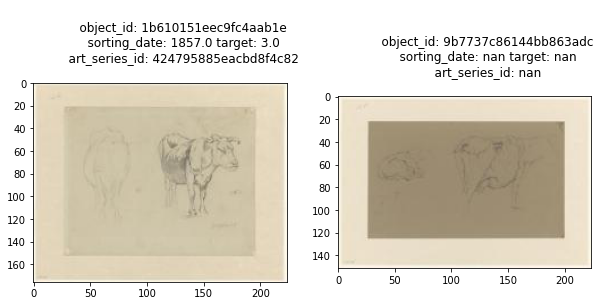

after: 3, before: 2.893137875


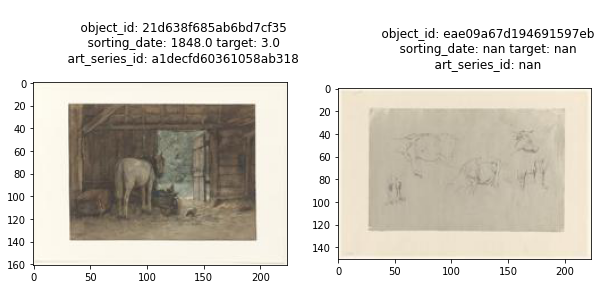

after: 2, before: 1.80402685


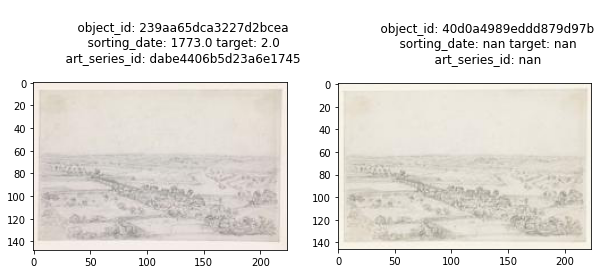

after: 2, before: 1.8332013


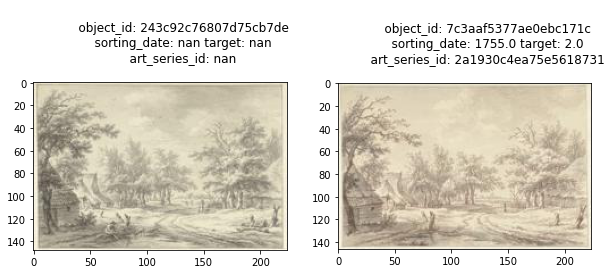

after: 2, before: 2.097656225


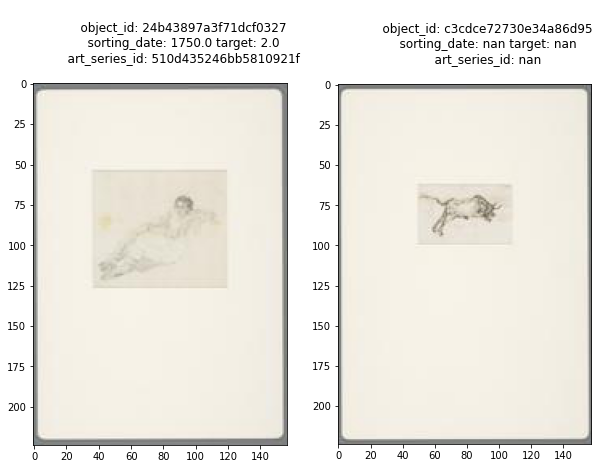

after: 3, before: 1.56311855


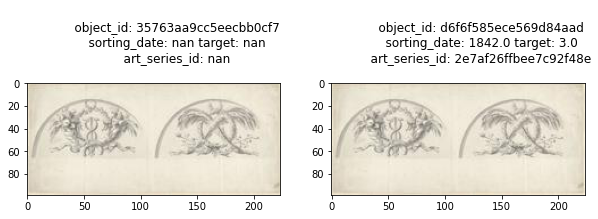

after: 2, before: 2.0285717


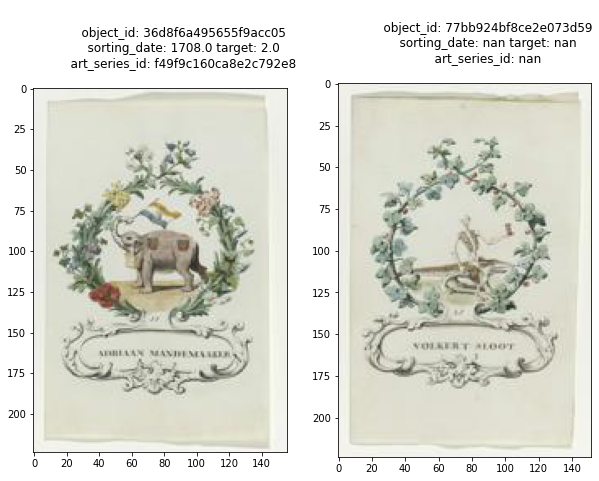

after: 2, before: 1.6347242750000002


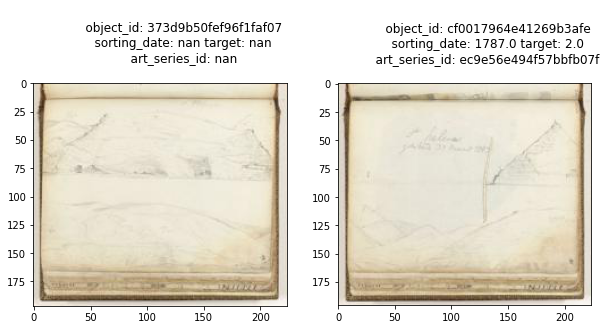

after: 0, before: 0.226034995


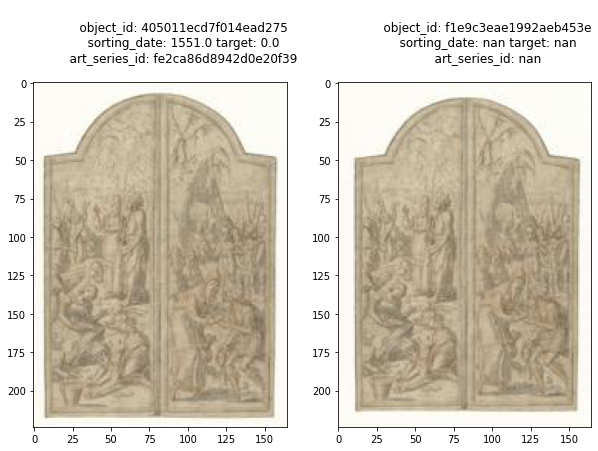

after: 3, before: 2.9487797


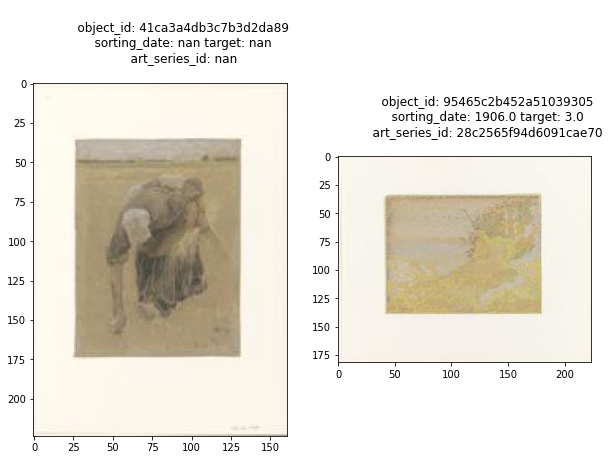

after: 0, before: 2.9495548


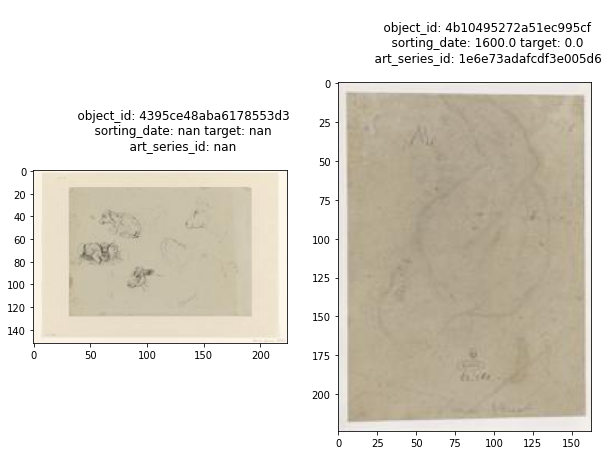

after: 3, before: 2.356403225


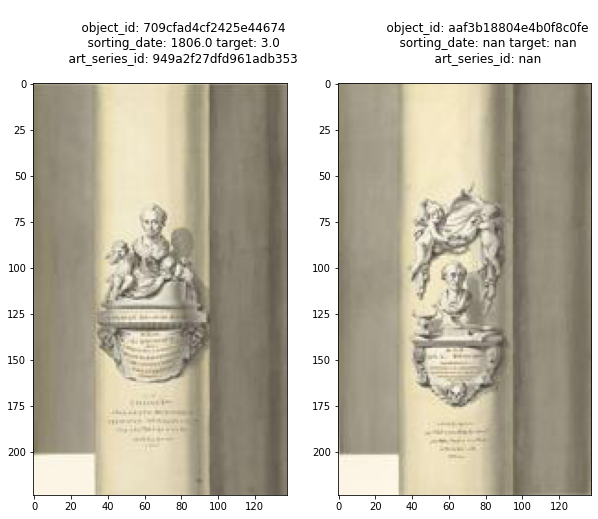

after: 2, before: 1.912378125


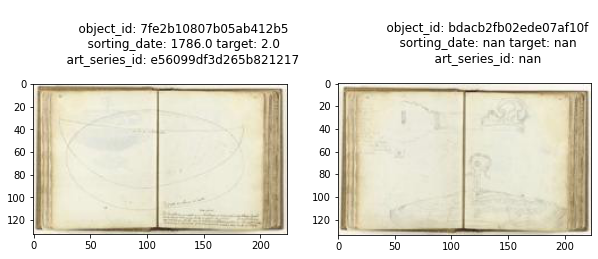

after: 3, before: 2.66101525


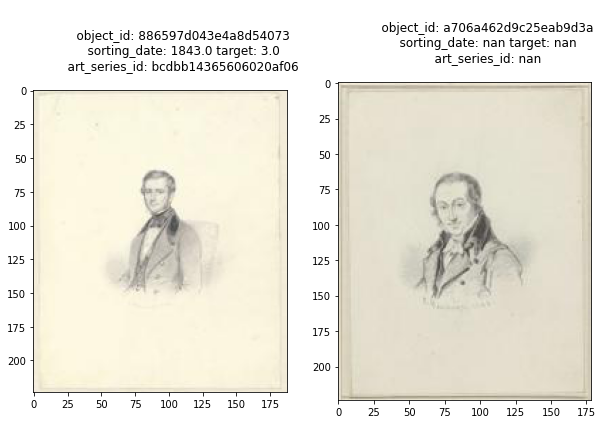

after: 2, before: 2.052182675


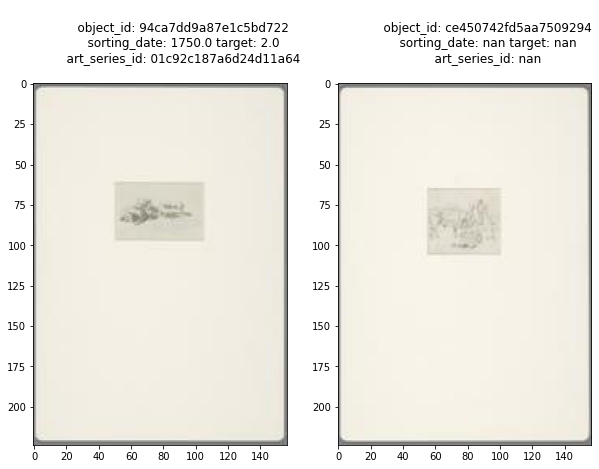

after: 3, before: 2.074712325


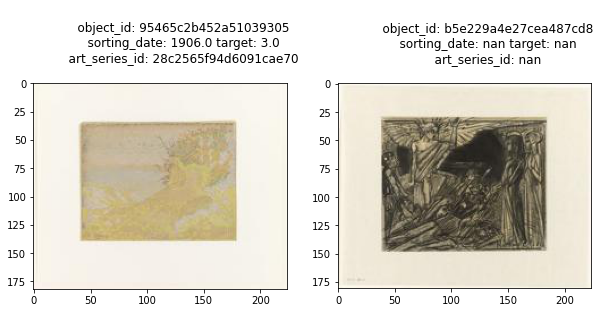

after: 3, before: 1.893654325


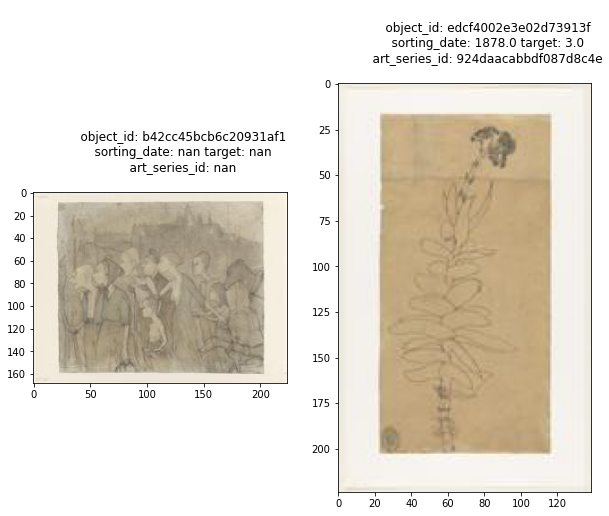

after: 0, before: 2.96661175


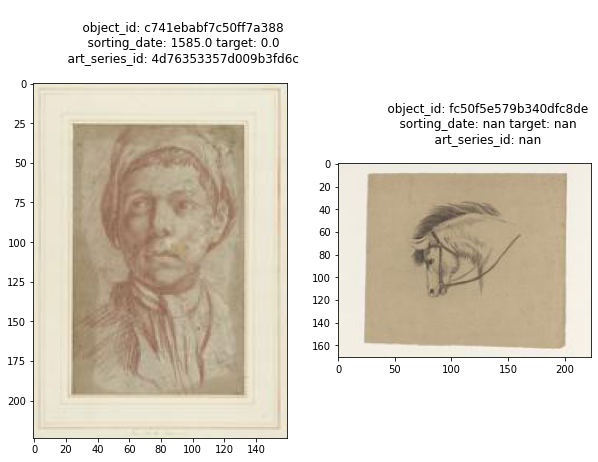

In [63]:
submission = pd.read_csv('../exp/ens_mean01/submission.csv')
for object_id1, object_id2 in sorted(list(dups)):
    
    def show(row1, row2):
        fig = plt.figure(figsize=(10, 20))
        fig.add_subplot(1,2,1)
        plt.title(f"""
            object_id: {row1['object_id'].iloc[0]}
            sorting_date: {row1['sorting_date'].iloc[0]} target: {row1['target'].iloc[0]}
            art_series_id: {row1['art_series_id'].iloc[0]}
        """)
        plt.imshow(read_image(object_id1))
        fig.add_subplot(1,2,2)
        plt.title(f"""
            object_id: {row2['object_id'].iloc[0]}
            sorting_date: {row2['sorting_date'].iloc[0]} target: {row2['target'].iloc[0]}
            art_series_id: {row2['art_series_id'].iloc[0]}
        """)
        plt.imshow(read_image(object_id2))
        plt.show()
    
    
    row1 = train_test[train_test["object_id"]==object_id1]
    row2 = train_test[train_test["object_id"]==object_id2]
    
    row1_is_test = row1['target'].isnull().iloc[0]
    row2_is_test = row2['target'].isnull().iloc[0]
#     print(row1['target'].iloc[0].isna())
#     print(row2_is_test)
    
    if row1_is_test and (not row2_is_test):
        after = train.loc[train['object_id']==object_id2, 'target'].values[0]
        before = submission.loc[test['object_id']==object_id1, 'target'].values[0]
        submission.loc[test['object_id']==object_id1, 'target'] = after
#         print('swapped1')
        print(f'after: {after}, before: {before}')
        show(row1, row2)
    elif row2_is_test and (not row1_is_test):
        
        after = train.loc[train['object_id']==object_id1, 'target'].values[0]
        before = submission.loc[test['object_id']==object_id2, 'target'].values[0]
        submission.loc[test['object_id']==object_id2, 'target'] = after
#         print('swapped1')
        print(f'after: {after}, before: {before}')
        show(row1, row2)

        
   

In [61]:
submission.to_csv(f'../exp/postprocess/submission_thresh={threshold}.csv', index=False)
submission

target
0     1.213467
1     2.190508
2     1.794432
3     2.016819
4     0.457805
...        ...
5914  2.826440
5915  1.404098
5916  1.798366
5917  1.789599
5918  0.441247

[5919 rows x 1 columns]

target
count  5919.000000
mean      1.808352
std       0.630253
min       0.000000
25%       1.435810
50%       1.880335
75%       2.227552
max       3.000000